# Spoon Feeding

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from copy import deepcopy
import pandas as pd
from astropy.table import Table
import astropy.constants as c
import astropy.units as u

mpl.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Ariel']
mpl.rcParams['font.size'] = '25'
mpl.rcParams['xtick.labelsize'] = '25'
mpl.rcParams['ytick.labelsize'] = '25'

## ASASSN-14ko

### $N$ v.s. $F_\mathrm{peak}$

In [2]:
Fpeak = np.array([
    4.24, 4.53, 4.26, np.nan,
    4.00, 4.07, np.nan, 4.14, 
    4.07, 4.06, 4.19,
    4.33, 4.40, np.nan,
    4.08, 4.24, np.nan,
    4.33, 4.39, 4.17
])
Fp_u = np.array([
    1.86, 3.49, 1.42, np.nan, 
    0.25, 7.09, np.nan, 1.18, 
    1.37, 1.32, 0.55, 
    0.16, 0.13, np.nan, 
    0.02, 0.07, np.nan,
    0.12, 0.11, 0.22
])
Fp_l = np.array([
    0.24, 0.13, 0.06, np.nan,
    0.01, 0.07, np.nan, 0.14,
    0.07, 0.16, 0.19,
    0.13, 0.10, np.nan,
    0.08, 0.04, np.nan,
    0.13, 0.09, 0.09
])

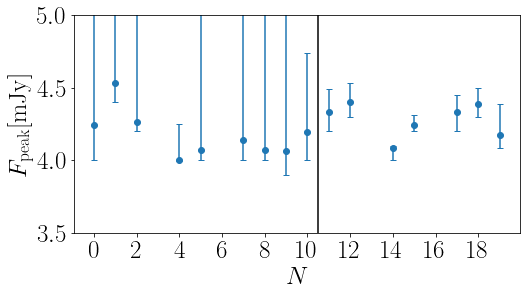

In [3]:
plt.figure(figsize=(8, 4))
plt.errorbar(np.arange(len(Fpeak)), Fpeak, yerr=[Fp_l, Fp_u], fmt='o', capsize=3)
#plt.yscale('log')
plt.ylabel(r'$F_\mathrm{peak} [\mathrm{mJy}]$', fontsize=25)
plt.xlabel(r'$N$', fontsize=25)
plt.xticks(np.arange(len(Fpeak)//2)*2)
plt.ylim(3.5, 5)
plt.axvline(10.5, color='k')
plt.show()

In [4]:
ts = 20 * u.day
Lp = 10**44.5 * u.erg / u.second
eff = 0.01
dM = (Lp * ts / eff / c.c**2).to('Msun')
dM

<Quantity 0.03057711 solMass>

## Mass Stripping

$$\Delta M(\beta)=f(\beta)\left(\frac{M_*-m_\text c}{M_*}\right)^2M_*$$

In [5]:
def DeltaM(beta, M, Mc):
    f = np.min([np.max([beta / 2 - 1 / 4, 0]), 1])
    return f * ((M - Mc) / M)**2 * M

## Stellar Evolution

$$\frac{R_*}{R_0}=\left(\frac{M_*}{M_0}\right)^{\xi_\text{ad}}$$

where

$$
\xi_\text{ad}\simeq\frac1{3-n}\left(1-n+\frac{m_c}{M_*-m_c}\right)
$$

Here $n$ is the polytropic index. For a stable star $n<3$.

In [6]:
def xi(mc, n):
    return (1 - n + mc / (1 - mc)) / (3 - n)

## Orbital Evolution

The orbital parameters of the bound giant star remnant are therefore essentially unchanged following the passage by the SMBH. As a result, in subsequent orbits the star will return to the same pericenter distance with a similar orbital period (MacLeod et al. 2013). But as the stellar radius evolves as the star is stripped by the SMBH, $\beta$ evolves.

$$
\beta=\frac{r_T}{r_p}
$$

where the tidal radius $r_T$ is given by

$$
r_T=R_*\left(\frac{M_\text{H}}{M_*}\right)^{1/3}=R_0\left(\frac{M_\text{H}}{M_0}\right)^{1/3}\left(\frac{M_*}{M_0}\right)^{\xi_\text{ad}-1/3}
$$

Thus

$$
\beta=\beta_0\left(\frac{M_*}{M_0}\right)^{\xi_\text{ad}-1/3}
$$

In [7]:
Mbh = 10**7.8 * u.Msun
P = 114 * u.day
a = ((c.G * Mbh / 4 / np.pi**2) * P**2)**(1 / 3)
rT = lambda M: (R * (Mbh / M)**(1 / 3)).cgs

## Test

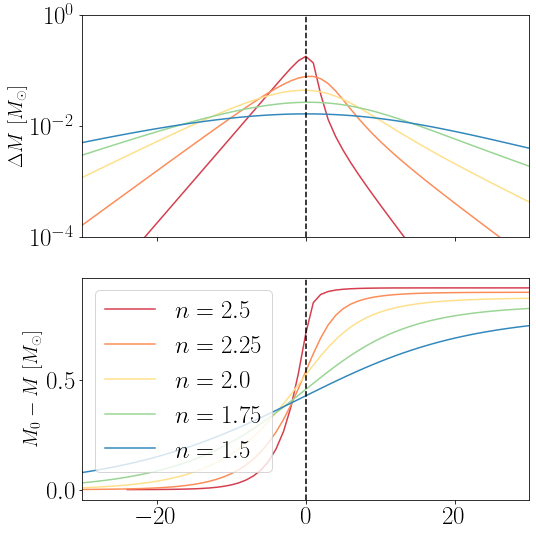

In [8]:
M0 = 1.4
Mc = 0.3
n = np.linspace(2.5, 1.5, 5)
beta0 = 0.5001
Beta, DM, MS = [], [], []
for j in range(len(n)):
    Beta.append([])
    DM.append([])
    MS.append([])
    beta = deepcopy(beta0)
    M = deepcopy(M0)
    while beta > 0.5000001:
        dM = DeltaM(beta, M, Mc)
        M -= dM
        x = xi(Mc / M, n[j])
        beta = beta0 * (M / M0)**(x - 1 / 3)
        Beta[j] = np.append(Beta[j], beta)
        DM[j] = np.append(DM[j], dM)
        MS[j] = np.append(MS[j], M)

l = 30
for i in range(len(Beta)):
    arg = np.argmax(DM[i])

    def center(arr, l=l):
        Arr = np.ones(2 * l + 1) * np.nan
        Min = np.max([arg - l, 0])
        Max = np.min([arg + l + 1, len(arr)])
        Arr[l - arg + Min:l - arg + Max] = np.array(arr)[Min:Max]
        return Arr

    Beta[i] = center(Beta[i])
    DM[i] = center(DM[i])
    MS[i] = center(MS[i])

f, ax = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
col = ['#d53e4f', '#fc8d59', '#fee08b', '#99d594', '#3288bd', '#e6f598']
k = 0
for dm, beta, mm in zip(DM, Beta, MS):
    ax[0].plot(np.arange(2 * l + 1) - l, dm, color=col[k])
    ax[1].plot(np.arange(2 * l + 1) - l,
               M0 - mm,
               color=col[k],
               label='$n = {}$'.format(n[k]))
    k += 1
ax[0].axvline(linestyle='--', color='k')
ax[1].axvline(linestyle='--', color='k')

ax[0].set_ylim([1e-4, 1])
ax[0].set_yscale('log')
ax[0].set_xlim([-l, l])

ax[0].set_ylabel(r'$\Delta M\ [M_\odot]$', fontsize=20)
ax[1].set_ylabel(r'$M_0-M\ [M_\odot]$', fontsize=20)

f.tight_layout()
ax[1].legend()

In [9]:
colnames = ['TIME', 'Wavelength', 'Flux', 'Error', 'Units']

a14ko = pd.read_csv('a14ko_arXiv2009.03321.txt',
                    skiprows=38,
                    sep='\s+',
                    encoding="utf-8",
                    names=colnames,
                    header=None)

In [10]:
a14kohostmags = pd.read_csv('a14ko_host_magnitudes.txt',sep='\t+')
a14kohostmags

/opt/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,Filter,Magnitude,Uncertainty
0,UVW2,16.56,0.02
1,UVM2,16.58,0.02
2,UVW1,16.43,0.02
3,U,15.95,0.02
4,B,15.26,0.01
5,g,15.00,0.01
6,V,14.77,0.01
7,r,14.46,0.01
8,R,14.48,0.01
9,i,14.23,0.01


In [11]:
#band=np.unique(a14ko['Wavelength'])
band = np.array([
    'B', 'M2', 'TESS', 'U', 'V', 'W1', 'W2', 'c', 'g', 'i', 'o', 'r', 'X-ray'
])
wav = np.array([
    4392.06, 2246, 7697.58, 3465, 5468, 2600, 1928, 5287.71, 4774.12, 7620.51,
    6750.17, 6227.46, 12.4
])
##Note that 12.4 corresponds to 1 keV in Angstroms (i.e., for the X-ray wavelengths).

In [12]:
def flam2mag(flux, wav):
    VV = flux * u.erg / u.s / u.cm**2 / u.AA
    mags0 = VV.to(u.ABmag, u.spectral_density(wav * u.AA))
    mags = mags0.value
    return np.array(mags)


def hostmag2flam(mags, wav):
    VV = mags * u.ABmag
    mags0 = VV.to(u.erg / u.s / u.cm**2 / u.AA, u.spectral_density(wav * u.AA))
    mag = mags0.value
    return np.array(mag)


def flam2muJy(flux, wav):
    flux_density = flux * u.erg / u.s / u.cm**2 / u.AA
    muJy0 = flux_density.to(u.Jansky,
                            equivalencies=u.spectral_density(wav * u.AA)) * 1e6
    muJy = muJy0.value
    return np.array(muJy)

def table2muJy(band,
               wav,
               host_band=None):
    table = a14ko[a14ko['Wavelength'] == band]

    if (band in set(a14kohostmags['Filter'])) or (host_band != None):
        if host_band == None:
            host_band = band
        host = hostmag2flam(np.array(a14kohostmags[a14kohostmags['Filter'] ==
                                                   host_band]['Magnitude'])[0],
                            wav=wav)
        hosterr = host * (10**(0.4 * np.array(a14kohostmags[
            a14kohostmags['Filter'] == host_band]['Uncertainty'])[0]) - 1)
        temp = np.array([
            table['TIME'], table['Flux'] - host,
            (table['Error']**2 + hosterr**2)**(1 / 2)
        ]).transpose()
        #temp[temp[:, 1] < 0, 1] = temp[temp[:, 1] < 0, 2] / 2
    else:
        temp = np.array([table['TIME'], table['Flux'],
                         table['Error']]).transpose()

    muJy = temp.copy()
    muJy[:, 1] = flam2muJy(temp[:, 1], wav=wav)
    muJy[:, 2] = flam2muJy(temp[:, 2], wav=wav)
    return muJy

(array([  1.,   1.,   0.,   1.,   3.,  11., 110., 180.,  76.,  42.,  27.,
         13.,  21.,   9.,   9.,   6.,   1.,   2.,   0.,   1.]),
 array([-1019.26449031,  -889.37292746,  -759.4813646 ,  -629.58980175,
         -499.6982389 ,  -369.80667604,  -239.91511319,  -110.02355033,
           19.86801252,   149.75957538,   279.65113823,   409.54270108,
          539.43426394,   669.32582679,   799.21738965,   929.1089525 ,
         1059.00051536,  1188.89207821,  1318.78364106,  1448.67520392,
         1578.56676677]),
 [<matplotlib.patches.Polygon at 0x7fb54a1e1ac0>])

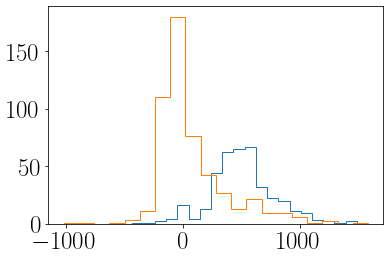

In [13]:
plt.hist(table2muJy('V', wav=wav[4])[:, 1], bins=20, histtype='step')
plt.hist(table2muJy('g', wav=wav[8])[:, 1], bins=20, histtype='step')

355.55187581731485


<ErrorbarContainer object of 3 artists>

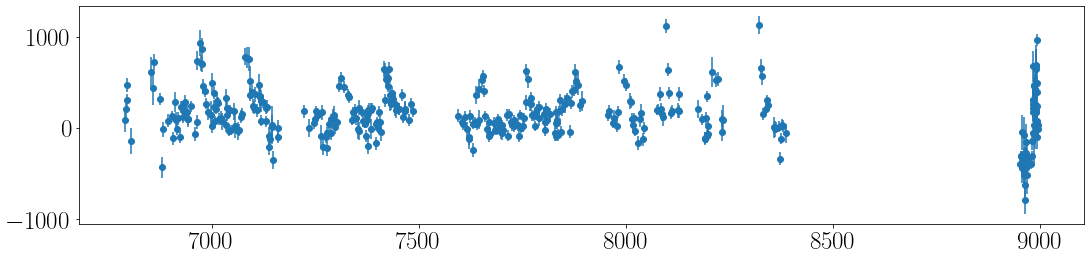

In [14]:
f, ax = plt.subplots(figsize=(18, 4), sharex=True)
ASV = table2muJy('V', wav=wav[4])
print(np.median(ASV[ASV[:, 1] < 500, 1]))
ASV[:, 1] -= np.median(ASV[ASV[:, 1] < 500, 1])

ax.errorbar(ASV[:, 0] - 2450000, ASV[:, 1], yerr=ASV[:, 2], fmt='o')

-40.80126881211207


<ErrorbarContainer object of 3 artists>

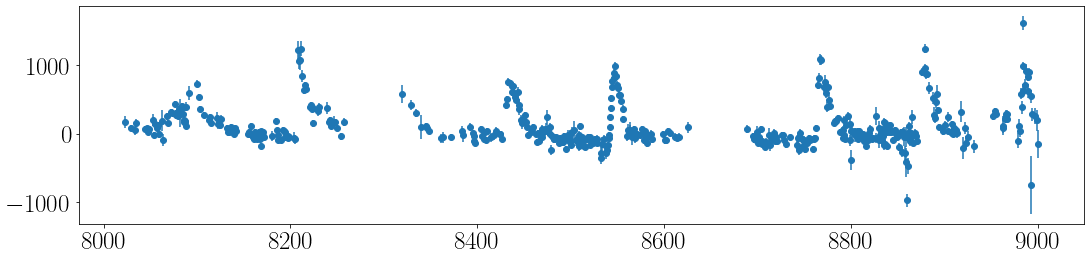

In [15]:
f, ax = plt.subplots(figsize=(18, 4), sharex=True)
ASg = table2muJy('g', wav=wav[8])
print(np.median(ASg[ASg[:, 1] < 500, 1]))
ASg[:, 1] -= np.median(ASg[ASg[:, 1] < 500, 1])
ax.errorbar(ASg[:, 0]-2450000, ASg[:, 1], yerr=ASg[:, 2], fmt='o')

In [16]:
def ratio(wav):
    T = 10**4.5 * u.K
    nu = c.c / (wav * u.AA)
    Fnu = 8 * np.pi * c.h * nu**3 / c.c**2 / (np.exp(c.h * nu / c.k_B / T) - 1)
    Flam = nu**2 / c.c * Fnu
    F = c.sigma_sb * T**4
    fnu = Fnu.to('Jansky').value * 1e6
    ftot = F.to('erg/s/cm**2').value

    DL = 194.084 * u.Mpc
    S = (4 * np.pi * DL**2).to('cm**2').value

    return 1 / fnu * ftot * S / (
        c.c.to('cm/s').value)**2 / u.Msun.to('g') * 86400 / eff

In [17]:
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, WhiteKernel


def fit_flare(date, y, yerr, length_scale_upper=1.8e1):
    kernel = 1 * RBF(length_scale=1e0,
                     length_scale_bounds=(1e-1, length_scale_upper)) + 0.1 * WhiteKernel(
                         noise_level=1e-8, noise_level_bounds=(1e-10, 1e-6))
    gp = GPR(kernel=kernel, alpha=yerr**2, n_restarts_optimizer=200)
    gp.fit(np.atleast_2d(date).T, y)

    return gp

/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 18.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kerne

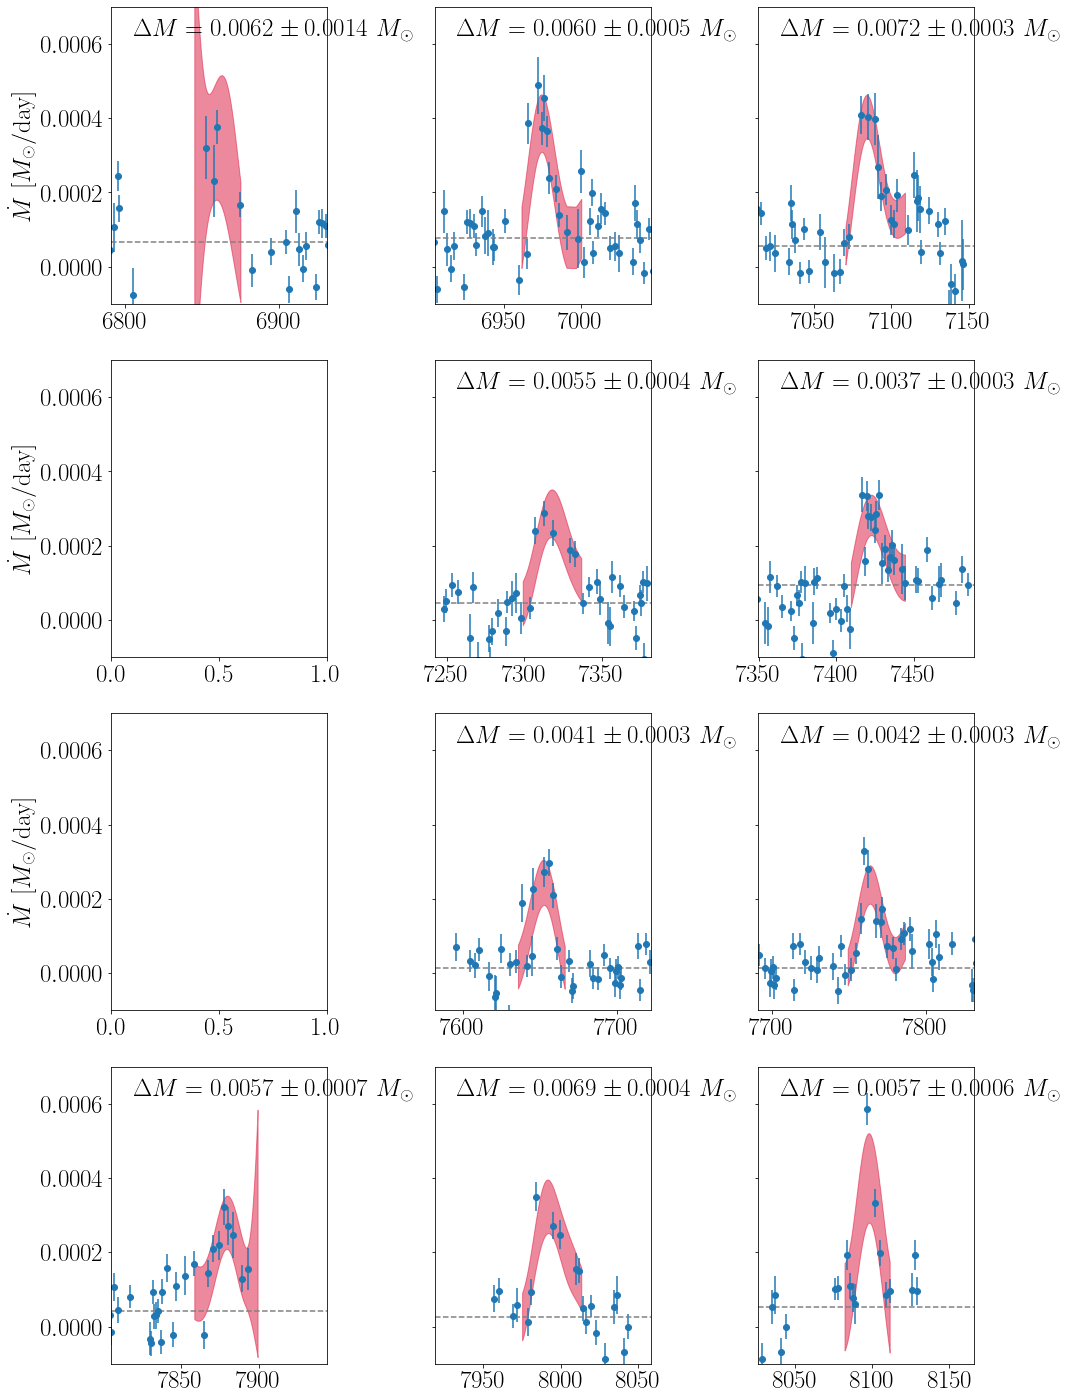

In [18]:
eff = 0.01

dat = np.linspace(-16, 25, 200)

# V-band
f, ax = plt.subplots(4, 3, figsize=(15, 20), sharey=True)
ax = ax.flatten()
dM_a14ko, dM_u_a14ko, dM_l_a14ko = [], [], []
peaks = np.array([
    11.2, 125, 233.8, 233.8 + 114, 461.8, 569.4, 569.4 + 114, 801.9, 911.4,
    1024.4, 1138.4, 1246.2, 2137.5
]) + 6850
ratio_V = ratio(wav[4])
ratio_g = ratio(wav[8])
for a, p in zip(ax, peaks):
    base = np.argwhere(((-70 < ASV[:, 0] - p - 2450000)
                        & (-30 > ASV[:, 0] - p - 2450000))
                       | ((30 < ASV[:, 0] - p - 2450000)
                          & (70 > ASV[:, 0] - p - 2450000)))
    baseline = np.nanpercentile(ASV[base, 1] * ratio_V, 50)

    arg = np.argwhere((-50 < ASV[:, 0] - p - 2450000)
                      & (50 > ASV[:, 0] - p - 2450000)).ravel()
    if len(arg) < 10:
        dM_a14ko = np.append(dM_a14ko, np.nan)
        dM_u_a14ko = np.append(dM_u_a14ko, np.nan)
        dM_l_a14ko = np.append(dM_l_a14ko, np.nan)
        continue
    date = ASV[arg, 0] - 2450000 - p
    y = (ASV[arg, 1]) * ratio_V
    yerr = ASV[arg, 2] * ratio_V
    a.errorbar(ASV[:, 0] - 2450000, (ASV[:, 1]) * ratio_V,
               yerr=ASV[:, 2] * ratio_V,
               fmt='o')
    gp = fit_flare(date, y, yerr)

    t = np.atleast_2d(dat).T
    pred, pred_unc = gp.predict(t, return_std=1)
    arg = np.argwhere(pred > baseline).flatten()
    a.fill_between(t.ravel()[arg] + p,
                   y1=(pred - pred_unc)[arg],
                   y2=(pred + pred_unc)[arg],
                   color='crimson',
                   alpha=.5)
    a.set_xlim(p - 70, p + 70)
    a.set_ylim(-1e-4, 7e-4)
    a.axhline(baseline, color='0.5', linestyle='--')

    M = (pred[arg] - baseline).sum() * (dat[arg[-1]] -
                                        dat[arg[0]]) / (len(arg) - 1)
    M_unc = ((pred_unc[arg]**2).sum() * (dat[arg[-1]] - dat[arg[0]]) /
             (len(arg) - 1))**.5
    dM_a14ko = np.append(dM_a14ko, M)
    dM_u_a14ko = np.append(dM_u_a14ko, M_unc)
    dM_l_a14ko = np.append(dM_l_a14ko, M_unc)

    a.text(0.1,
           0.9,
           r'$\Delta M={:.4f}\pm{:.4f}\ M_\odot$'.format(M, M_unc),
           transform=a.transAxes)

ax[0].set_ylabel('$\dot M\ [M_\odot/\mathrm{day}]$', fontsize=25)
ax[3].set_ylabel('$\dot M\ [M_\odot/\mathrm{day}]$', fontsize=25)
ax[6].set_ylabel('$\dot M\ [M_\odot/\mathrm{day}]$', fontsize=25)
f.tight_layout()
dM_a14ko_V = dM_a14ko
dM_l_a14ko_V = dM_l_a14ko
dM_u_a14ko_V = dM_u_a14ko
plt.show()

/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kerne

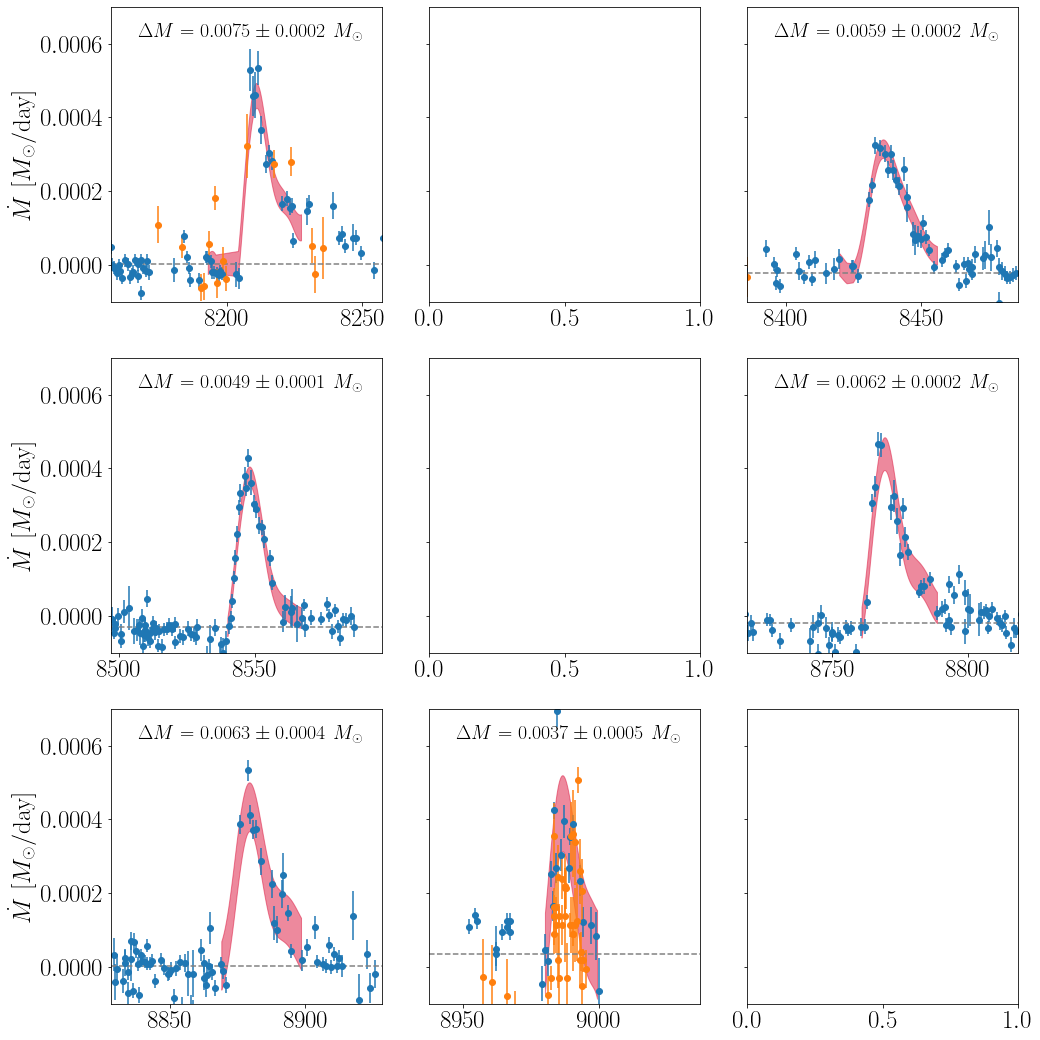

In [19]:
dat = np.linspace(-16, 20, 500)

# g-band
f, ax = plt.subplots(3, 3, figsize=(15, 15), sharey=True)
ax = ax.flatten()
dM_a14ko, dM_u_a14ko, dM_l_a14ko = [], [], []
peaks = np.array(
    [1360.4 - 3, 1472, 1585.7, 1697.1, 1808, 1918.5, 2028.4, 2137.5]) + 6850
ratio_V = ratio(wav[4])
ratio_g = ratio(wav[8])
num = 0
for a, p in zip(ax, peaks):
    num += 1
    base = np.argwhere(((-70 < ASg[:, 0] - p - 2450000)
                        & (-30 > ASg[:, 0] - p - 2450000))
                       | ((30 < ASg[:, 0] - p - 2450000)
                          & (70 > ASg[:, 0] - p - 2450000)))
    baseline = np.nanpercentile(ASg[base, 1] * ratio_g, 50)

    arg = np.argwhere((-50 < ASg[:, 0] - p - 2450000)
                      & (50 > ASg[:, 0] - p - 2450000)).ravel()
    if len(arg) < 20:
        dM_a14ko = np.append(dM_a14ko, np.nan)
        dM_u_a14ko = np.append(dM_u_a14ko, np.nan)
        dM_l_a14ko = np.append(dM_l_a14ko, np.nan)
        continue
    date = ASg[arg, 0] - 2450000 - p
    y = ASg[arg, 1] * ratio_g
    yerr = ASg[arg, 2] * ratio_g
    a.errorbar(ASg[:, 0] - 2450000,
               ASg[:, 1] * ratio_g,
               yerr=ASg[:, 2] * ratio_g,
               fmt='o')
    a.errorbar(ASV[:, 0] - 2450000,
               ASV[:, 1] * ratio_V,
               yerr=ASV[:, 2] * ratio_V,
               fmt='o')
    gp = fit_flare(date, y, yerr, length_scale_upper=1e1)
    t = np.atleast_2d(dat).T
    pred, pred_unc = gp.predict(t, return_std=1)
    arg = np.argwhere(pred > baseline).ravel()
    a.fill_between(t.ravel()[arg] + p,
                   y1=(pred - pred_unc)[arg],
                   y2=(pred + pred_unc)[arg],
                   color='crimson',
                   alpha=.5)
    a.set_xlim(p - 50, p + 50)
    a.set_ylim(-1e-4, 7e-4)
    a.axhline(baseline, color='0.5', linestyle='--')

    M = (pred[arg] - baseline).sum() * (dat[arg[-1]] -
                                        dat[arg[0]]) / (len(arg) - 1)
    M_unc = ((pred_unc[arg]**2).sum() * (dat[arg[-1]] - dat[arg[0]]) /
             (len(arg) - 1))**.5
    dM_a14ko = np.append(dM_a14ko, M)
    dM_u_a14ko = np.append(dM_u_a14ko, M_unc)
    dM_l_a14ko = np.append(dM_l_a14ko, M_unc)

    if num == 7:
        np.savetxt('May2020_ASASSN_g.txt',
                   [t.ravel()[arg],
                   pred[arg] * 365.25])  #save the 2020 May flare

    a.text(0.1,
           0.9,
           r'$\Delta M={:.4f}\pm{:.4f}\ M_\odot$'.format(M, M_unc),
           transform=a.transAxes, fontsize=20)

ax[0].set_ylabel('$\dot M\ [M_\odot/\mathrm{day}]$', fontsize=25)
ax[3].set_ylabel('$\dot M\ [M_\odot/\mathrm{day}]$', fontsize=25)
ax[6].set_ylabel('$\dot M\ [M_\odot/\mathrm{day}]$', fontsize=25)
f.tight_layout()
dM_a14ko_g = dM_a14ko
dM_l_a14ko_g = dM_l_a14ko
dM_u_a14ko_g = dM_u_a14ko
plt.show()

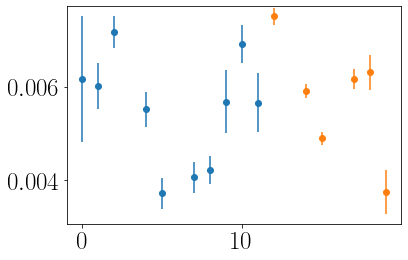

In [20]:
plt.errorbar(np.arange(12),
             dM_a14ko_V,
             yerr=[dM_l_a14ko_V, dM_u_a14ko_V],
             fmt='o')
plt.errorbar(np.arange(8) + 12,
             dM_a14ko_g,
             yerr=[dM_l_a14ko_g, dM_u_a14ko_g],
             fmt='o')
dM_a14ko = np.append(dM_a14ko_V, dM_a14ko_g)
dM_l_a14ko = np.append(dM_l_a14ko_V, dM_l_a14ko_g)
dM_u_a14ko = np.append(dM_u_a14ko_V, dM_u_a14ko_g)

In [21]:
def data_binning(x, size=3, min_bin=1):
    t, out, outyerr = [], [], []
    t0 = x[0][np.argwhere(~np.isnan(x[1])).flatten()]
    outyerr0 = x[2][np.argwhere(~np.isnan(x[1])).flatten()]
    out0 = x[1][np.argwhere(~np.isnan(x[1])).flatten()]
    for i in range(len(x[0]) // size):
        if len(t0[i * size:(i + 1) *
                  size][~np.isnan(out0[i * size:(i + 1) * size])]) < min_bin:
            continue
        weight = np.nansum(1 / outyerr0[i * size:(i + 1) * size]**2)
        t = np.append(
            t,
            np.nansum(t0[i * size:(i + 1) * size] /
                      outyerr0[i * size:(i + 1) * size]**2) / weight)
        out = np.append(
            out,
            np.nansum(out0[i * size:(i + 1) * size] /
                      outyerr0[i * size:(i + 1) * size]**2) / weight)
        std = np.nanstd(out0[i * size:(i + 1) * size], ddof=1)
        yerr = 0#np.nansum(outyerr0[i * size:(i + 1) * size]**2)**.5 / size
        outyerr = np.append(outyerr, (std**2 + yerr**2)**.5)
    return t, out, outyerr

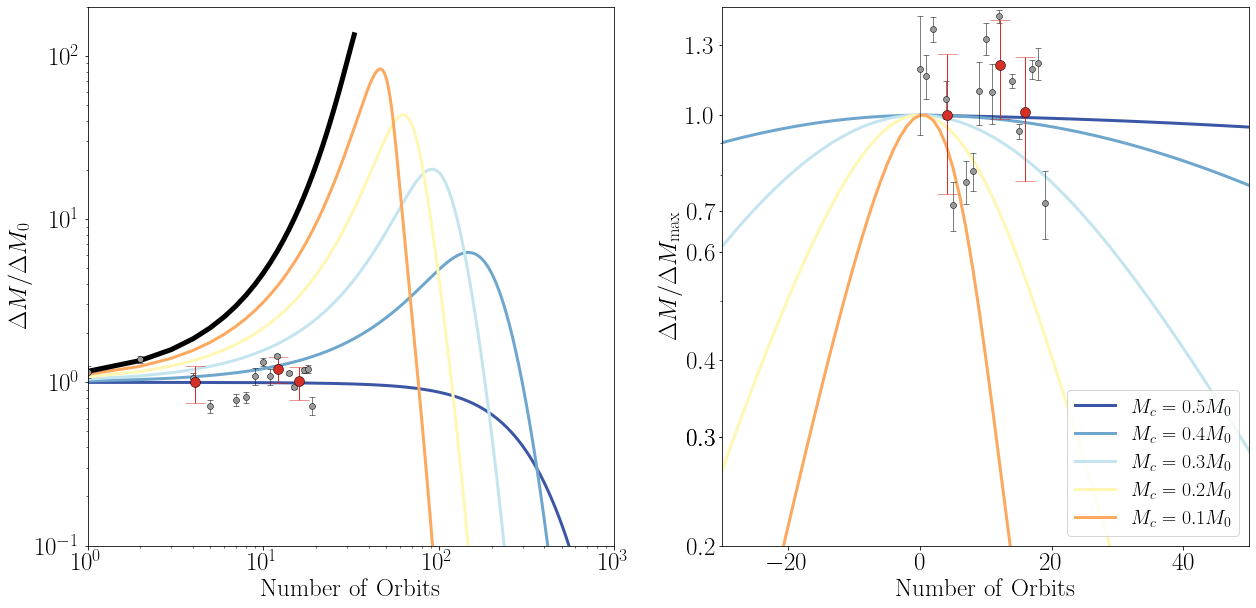

In [52]:
M0 = 1.4
l = 6
Mc = np.linspace(0.7, 0, l)
n = 1.5
beta0 = 0.501

f, ax = plt.subplots(1, 2, figsize=(18, 9))

Beta, DM, MS = [], [], []
Beta0, DM0, MS0 = [], [], []
for j in range(len(Mc)):
    Beta.append([])
    DM.append([])
    MS.append([])

    beta, M = deepcopy(beta0), deepcopy(M0)
    while beta > 0.5000001:
        dM = DeltaM(beta, M, Mc[j])
        M = M - dM
        x = xi(Mc[j] / M, n)
        beta = beta0 * (M / M0)**(x - 1 / 3)
        Beta[j] = np.append(Beta[j], beta)
        DM[j] = np.append(DM[j], dM)
        MS[j] = np.append(MS[j], M)
        if Mc[j] == 0 and M < 5e-1 * M0:
            break
col = cm.get_cmap('RdYlBu_r', 300)
color = [col(((k + 0.5) / l)**1.2) for k in range(l)]
color[l - 1] = 'k'
for k, (dm, mm) in enumerate(zip(DM, MS)):
    l = len(dm)
    arg = np.argmax(dm)
    if Mc[k] > 0:
        label = '$M_c={:.1f}M_0$'.format(Mc[k] / M0)
        lw = 3
    else:
        label = '$\mathrm{No\ core}$'
        lw = 5
    ax[0].plot(
        np.arange(l),
        dm / dm[0],  #.mean(),
        color=color[k],
        label=label,
        linewidth=lw)
    if k < 5:
        ax[1].plot(
            np.arange(l) - arg,
            dm / dm[arg],  #.mean(),
            color=color[k],
            label=label,
            linewidth=lw)

yerr_a14ko = np.array([dM_l_a14ko, dM_u_a14ko])  #np.nanmean(),
N0 = np.arange(len(dM_a14ko)) + 1
t, out, outyerr = data_binning(np.array(
    [N0, dM_a14ko, (yerr_a14ko[0] + yerr_a14ko[1]) / 2]),
                               size=6,
                               min_bin=3)
for x in ax:
    x.errorbar(N0 - N0[0],
               dM_a14ko / out[0],
               yerr=yerr_a14ko / out[0],
               fmt='o',
               color='0.6',
               markeredgecolor='k',
               markeredgewidth=.5,
               ecolor='k',
               elinewidth=.5,
               capsize=3)
    x.errorbar(
        t - N0[0],
        out / out[0],
        yerr=outyerr / out[0],
        fmt='o',
        markeredgewidth=.5,
        markeredgecolor='k',
        color=col(270),
        ms=10,
        #ecolor='k',
        elinewidth=1,
        capsize=10)
    x.set_xlabel(r'$\mathrm{Number\ of\ Orbits}$')
    x.set_yscale('log')

ax[1].set_ylabel(r'$\Delta M/\Delta M_\mathrm{max}$')
ax[0].set_ylabel(r'$\Delta M/\Delta M_0$')
ax[1].set_xlim(-30, 50)
ax[1].set_ylim(3e-1, 1.5e0)
ax[0].set_ylim(1e-1, 2e2)
ax[0].set_xlim(1e0, 1e3)
ax[0].set_xscale('log')
#ax.set_xscale('symlog', linthresh=10)
ax[1].legend(loc='lower right', prop={'size': 20})
ax[1].yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
#ax.yaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())
ax[1].set_yticks(np.logspace(np.log10(.2), 0.1, 8).round(1))

f.tight_layout()
f.savefig('Flare_evolution.pdf')

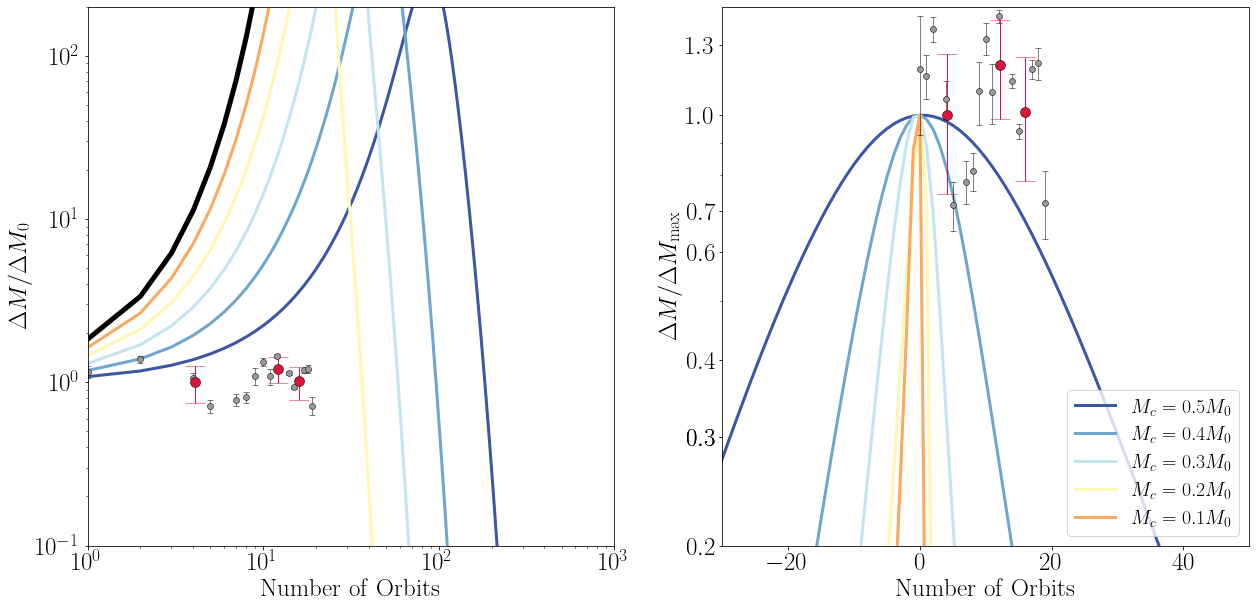

In [51]:
M0 = 1.4
l = 6
Mc = np.linspace(0.7, 0, l)
n = 2.5
beta0 = 0.5001

f, ax = plt.subplots(1, 2, figsize=(18, 9))

Beta, DM, MS = [], [], []
Beta0, DM0, MS0 = [], [], []
for j in range(len(Mc)):
    Beta.append([])
    DM.append([])
    MS.append([])

    beta, M = deepcopy(beta0), deepcopy(M0)
    while beta > 0.5000001:
        dM = DeltaM(beta, M, Mc[j])
        M = M - dM
        x = xi(Mc[j] / M, n)
        beta = beta0 * (M / M0)**(x - 1 / 3)
        Beta[j] = np.append(Beta[j], beta)
        DM[j] = np.append(DM[j], dM)
        MS[j] = np.append(MS[j], M)
        if Mc[j] == 0 and M < 5e-1 * M0:
            break
col = cm.get_cmap('RdYlBu_r', 300)
color = [col(((k + 0.5) / l)**1.2) for k in range(l)]
color[l - 1] = 'k'
for k, (dm, mm) in enumerate(zip(DM, MS)):
    l = len(dm)
    arg = np.argmax(dm)
    if Mc[k] > 0:
        label = '$M_c={:.1f}M_0$'.format(Mc[k] / M0)
        lw = 3
    else:
        label = '$\mathrm{No\ core}$'
        lw = 5
    ax[0].plot(
        np.arange(l),
        dm / dm[0],  #.mean(),
        color=color[k],
        label=label,
        linewidth=lw)
    if k < 5:
        ax[1].plot(
            np.arange(l) - arg,
            dm / dm[arg],  #.mean(),
            color=color[k],
            label=label,
            linewidth=lw)

yerr_a14ko = np.array([dM_l_a14ko, dM_u_a14ko])  #np.nanmean(),
N0 = np.arange(len(dM_a14ko)) + 1
t, out, outyerr = data_binning(np.array(
    [N0, dM_a14ko, (yerr_a14ko[0] + yerr_a14ko[1]) / 2]),
                               size=6,
                               min_bin=3)
for x in ax:
    x.errorbar(N0 - N0[0],
               dM_a14ko / out[0],
               yerr=yerr_a14ko / out[0],
               fmt='o',
               color='0.6',
               markeredgecolor='k',
               markeredgewidth=.5,
               ecolor='k',
               elinewidth=.5,
               capsize=3)
    x.errorbar(
        t - N0[0],
        out / out[0],
        yerr=outyerr / out[0],
        fmt='o',
        markeredgewidth=.5,
        markeredgecolor='k',
        color='crimson',
        ms=10,
        #ecolor='k',
        elinewidth=1,
        capsize=10)
    x.set_xlabel(r'$\mathrm{Number\ of\ Orbits}$')
    x.set_yscale('log')

ax[1].set_ylabel(r'$\Delta M/\Delta M_\mathrm{max}$')
ax[0].set_ylabel(r'$\Delta M/\Delta M_0$')
ax[1].set_xlim(-30, 50)
ax[1].set_ylim(3e-1, 1.5e0)
ax[0].set_ylim(1e-1, 2e2)
ax[0].set_xlim(1e0, 1e3)
ax[0].set_xscale('log')
#ax.set_xscale('symlog', linthresh=10)
ax[1].legend(loc='lower right', prop={'size': 20})
ax[1].yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
#ax.yaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())
ax[1].set_yticks(np.logspace(np.log10(.2), 0.1, 8).round(1))

f.tight_layout()

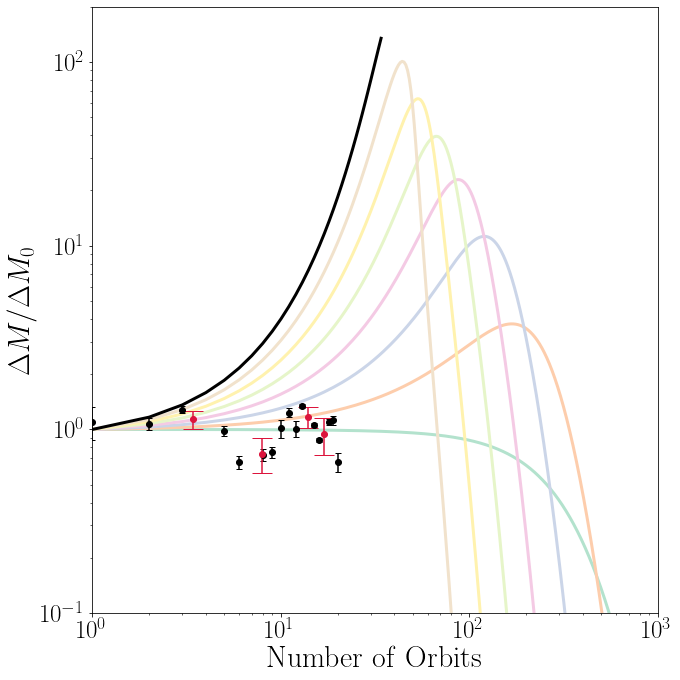

In [27]:
M0 = 1.4
l = 8
Mc = np.linspace(0.7, 0, l)
n = 1.5
beta0 = 0.501

f, ax = plt.subplots(figsize=(10, 10), sharex=True)

Beta, DM, MS = [], [], []
Beta0, DM0, MS0 = [], [], []
for j in range(len(Mc)):
    Beta.append([])
    DM.append([])
    MS.append([])

    beta, M = deepcopy(beta0), deepcopy(M0)
    while beta > 0.5000001:
        dM = DeltaM(beta, M, Mc[j])
        M -= dM
        x = xi(Mc[j] / M, n)
        beta = beta0 * (M / M0)**(x - 1 / 3)
        Beta[j] = np.append(Beta[j], beta)
        DM[j] = np.append(DM[j], dM)
        MS[j] = np.append(MS[j], M)
        if Mc[j] == 0 and M < 5e-1 * M0:
            break
col = cm.get_cmap('Pastel2')
color = [col(k / l) for k in range(l)]
color[l - 1] = 'k'
for k, (dm, mm) in enumerate(zip(DM, MS)):
    l = len(dm)
    ax.plot(
        np.arange(l) + 1,
        dm / dm[0],  #.mean(),
        color=color[k],
        label='$M_c={}\ \M_\odot$'.format(Mc[k]),
        linewidth=3)

ax.set_xlabel(r'$\mathrm{Number\ of\ Orbits}$', fontsize=30)
ax.set_ylabel(r'$\Delta M/\Delta M_0$', fontsize=30)
ax.set_yscale('log')

yerr_a14ko = np.array([dM_l_a14ko, dM_u_a14ko]) / dM_a14ko[1]  #np.nanmean(),
N0 = np.arange(len(dM_a14ko)) + 1
plt.errorbar(N0,
             dM_a14ko / np.nanmean(dM_a14ko),
             yerr=yerr_a14ko,
             fmt='o',
             color='k',
             capsize=3)
t, out, outyerr = data_binning(np.array(
    [N0, dM_a14ko / np.nanmean(dM_a14ko),
     (yerr_a14ko[0] + yerr_a14ko[1]) / 2]),
                               size=4,
                               min_bin=3)

plt.errorbar(t, out, yerr=outyerr, fmt='o', color='crimson', capsize=10)
ax.set_xlim(1e0, 1e3)
ax.set_ylim(1e-1, 2e2)
ax.set_xscale('log')
#ax.legend()
ax.tick_params(labelsize=25)

f.tight_layout()
#f.savefig('Flare_evolution.pdf')

## $t_\text{peak}$

### Numerical Fitting

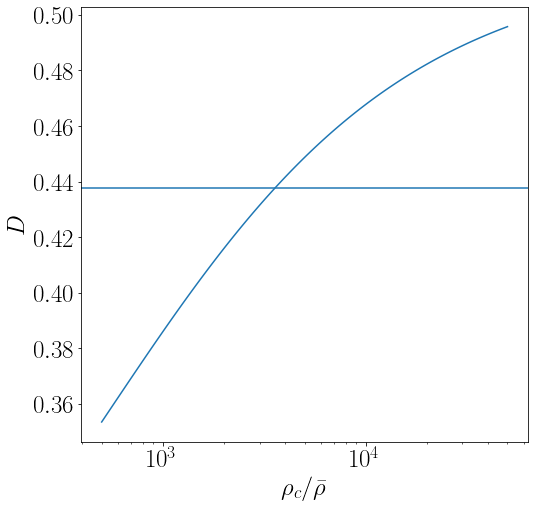

In [3]:
r_rho = 5 * np.logspace(2, 4, 100)
beta_crit = 0.39 * r_rho**(1 / 2.3)
beta = 0.5
alpha = r_rho**(-1 / 3)
x = np.exp((beta / beta_crit)**alpha - 1)
tpeak = (2 / x**12 + 17 * x + 8) * (7e7 / 1e6)**(1 / 2)
D = 1 - (1 + (tpeak / 114.2)**(-2 / 3))**(-3 / 2)

plt.figure(figsize=(8, 8))
plt.plot(r_rho, D)
plt.xlabel(r'$\rho_c/\bar\rho$')
plt.ylabel('$D$')
plt.xscale('log')
plt.axhline(50 / 114.2)